In [1]:
import re

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import dask_geopandas
from collections import OrderedDict

import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import netCDF4 as nc
from dotenv import load_dotenv

# 1. Setting up Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


# spark = SparkSession.builder.getOrCreate()

# only use 4 corea
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [3]:
spark

In [4]:
spark.sparkContext.defaultParallelism

4

In [7]:
# spark.stop()

# 2. Preparing NO2 Data

For NO2 data, I will be using OMI NO2 from NASA. This dataset is daily-level ar roughly 0.1deg * 0.1deg resolution. OMI instrument present in a satellite orbits the Earth 14 to 15 times a day and calculate NO2 vertical column density. Vertical Column Density or VCD refers to the total amount of NO2 molecules present from earth surface to the top of the atmosphere. NO2 pollution would be in tons that can be calculated from surface concentrations (NO2 molecules present on earth surface). This can be done using ground based sensors from EPA or PANDORA. 

Even though the data I am using is vertical columns, it still is a very good indicator of NO2 pollution. It is satellite-based data, which means we can do global-level data analysis and evaluation. Besides, the presence of sensors is very scarce and it is not possible to place ground-based sensors throughout the world. That's where satellite-based evaluation come in handy.

<b> Higher OMI NO2 VCD indicates more NO2 emissions from burning of fuel (cars), industries, etc. Furthermore, NO2 irritates the airways in our lungs and nose, causing inflammation and swelling, and is one of the top pollutants to cause respiratory disease like Asthma</b>

I wil be using `OMI_MINDS_NO2` dataset from NASA. You can find more about it from the following link: https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1


This data is also available on S3. I will be reading the files directly from S3. 

In [8]:
load_dotenv()

True

In [9]:
'''
This is how we can fetch temporary credentials from NASA's Earthdata to access AWS S3 bucket.
These expire after 1 hour. And, you need an active earthdata account to get the credentials.
This code is present on NASA's website:

https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME
'''

s3_endpoint = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
username = os.getenv("EARTHDATA_USERNAME")
password = os.getenv("EARTHDATA_PASSWORD")


login_resp = requests.get(s3_endpoint, allow_redirects=False)
login_resp.raise_for_status()

auth = f"{username}:{password}"
encoded_auth = base64.b64encode(auth.encode('ascii'))

auth_redirect = requests.post(
    login_resp.headers['location'],
    data={"credentials": encoded_auth},
    headers={"Origin": s3_endpoint},
    allow_redirects=False
)
auth_redirect.raise_for_status()

final = requests.get(auth_redirect.headers['location'], allow_redirects=False)
final.raise_for_status()

results = requests.get(s3_endpoint, cookies={'accessToken': final.cookies['accessToken']})
results.raise_for_status()

creds = json.loads(results.content)

In [10]:
# creating s3fs object to access the bucket using the retrieved temporaty credentials
s3_fs = s3fs.S3FileSystem(
        key = creds['accessKeyId'],
        secret = creds['secretAccessKey'],
        token = creds['sessionToken'],
    )

In [11]:
'''
The name of the S3 bucket that contains OMI NO2 data is gesdisc-cumulus-prod-protected.
Let's quickly test if we can connect to the bucket or not.
'''

try:
    files = s3_fs.ls("s3://gesdisc-cumulus-prod-protected")
    print("Connection successful! Files found:")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Files found:


We have set up our s3fs object and connected it to NASA's s3 bucket. Next thing will be to go on the NASA GESC DISC website and get the text file containing links to the s3 files for OMI NO2 from 2018 to 2022. The data is present inside `gesdisc-cumulus-prod-protected` bucket.

We can directly stream the data object into our RAM using `Xarray` python library. 

In [12]:
''''
These are the S3 links to OMI NO2 data files from year 2018 to 2022. I got this from NASA's GESC DISC.
You can get these links from the following URL:

https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1
'''

with open("OMI_NO2_S3_Links.txt", "r") as file:
    omi_no2_links = file.readlines()

omi_no2_links = [line.strip() for line in omi_no2_links]
omi_no2_links = [link for link in omi_no2_links if link.endswith(".nc")]
print("TOTAL NUMBER OF FILES IS: ", len(omi_no2_links))
omi_no2_links[:10]

TOTAL NUMBER OF FILES IS:  9196


['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2022/365/OMI-Aura_L2-OMI_MINDS_NO2_2022m1231t2250-o098205_v01-01-2023m0223t193712.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t0029-o098206_v01-01-2023m0223t193641.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1201-o098213_v01-01-2023m0223t193846.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1340-o098214_v01-01-2023m0223t193853.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1519-o098215_v01-01-2023m0223t193844.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1658-o098216_v01-01-2023m0223t193916.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101

Each file is roughly ~10mb in size (some can be larger and some can be smaller). With 23084 files, the total data size that we will be streaming will be ~250 GB. However, these files contain global data and we will filter data only for the US bounding cordinates. 

In [13]:
def is_over_us_state(lat: np.array, lon: np.array):
    """Returns True if (lat, lon) is inside any of the 50 US states (excluding territories)."""
    
    # Continental U.S. (CON 48 states)
    conus = (
        (24.5 <= lat <= 49.5) &  
        (-125.0 <= lon <= -66.95)  
    )
    
    # Alaska 
    alaska = (
        (51.0 <= lat <= 71.4) &  
        ((-170.0 <= lon <= -129.9)) 
    )
    
    # Hawaii
    hawaii = (
        (17.9 <= lat <= 26) &  
        (-162.0 <= lon <= -154.5)  
    )
    
    return conus | alaska | hawaii


In [9]:
global_latitude = []
global_longitude = []
global_ColumnAmountNO2 = []
global_cloudFraction = []
global_LAT1 = []
global_LAT2 = []
global_LAT3 = []
global_LAT4 = []
global_LON1 = []
global_LON2 = []
global_LON3 = []
global_LON4 = []
global_date = []

for current_file in tqdm(omi_no2_links[:30]):
    with s3_fs.open(current_file, mode="rb") as f:
        dataset = nc.Dataset("in-memory.nc", memory=f.read())

    filename = os.path.basename(current_file)
    date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
    ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
    cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
    latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
    longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
    corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
    corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
    LAT1 = corner_latitude[:, 0]
    LAT2 = corner_latitude[:, 1]
    LAT3 = corner_latitude[:, 2]
    LAT4 = corner_latitude[:, 3]
    LON1 = corner_longitude[:, 0]
    LON2 = corner_longitude[:, 1]
    LON3 = corner_longitude[:, 2]
    LON4 = corner_longitude[:, 3]
    date = np.repeat(date, ColumnAmountNO2.shape[0])

    boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])

    ColumnAmountNO2 = ColumnAmountNO2[boolean_mask]
    cloudFraction = cloudFraction[boolean_mask]
    latitude = latitude[boolean_mask]
    longitude = longitude[boolean_mask]
    LAT1 = LAT1[boolean_mask]
    LAT2 = LAT2[boolean_mask]
    LAT3 = LAT3[boolean_mask]
    LAT4 = LAT4[boolean_mask]
    LON1 = LON1[boolean_mask]
    LON2 = LON2[boolean_mask]
    LON3 = LON3[boolean_mask]
    LON4 = LON4[boolean_mask]
    date = date[boolean_mask]

    global_latitude.extend(latitude)
    global_longitude.extend(longitude)
    global_ColumnAmountNO2.extend(ColumnAmountNO2)
    global_cloudFraction.extend(cloudFraction)
    global_LAT1.extend(LAT1)
    global_LAT2.extend(LAT2)
    global_LAT3.extend(LAT3)
    global_LAT4.extend(LAT4)
    global_LON1.extend(LON1)
    global_LON2.extend(LON2)
    global_LON3.extend(LON3)
    global_LON4.extend(LON4)
    global_date.extend(date)

    dataset.close()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


In [10]:
global_latitude = np.array(global_latitude)
global_longitude = np.array(global_longitude)
global_ColumnAmountNO2 = np.array(global_ColumnAmountNO2)
global_cloudFraction = np.array(global_cloudFraction)
global_LAT1 = np.array(global_LAT1)
global_LAT2 = np.array(global_LAT2)
global_LAT3 = np.array(global_LAT3)
global_LAT4 = np.array(global_LAT4)
global_LON1 = np.array(global_LON1)
global_LON2 = np.array(global_LON2)
global_LON3 = np.array(global_LON3)
global_LON4 = np.array(global_LON4)
global_date = np.array(global_date)

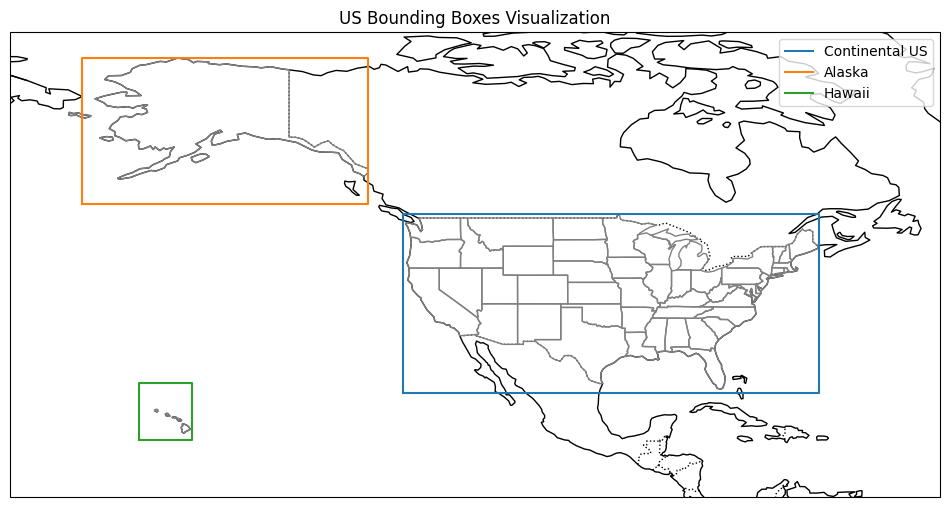

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-180, -50, 10, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray')

bounding_boxes = {
    "Continental US": [[24.5, 49.5], [-125.0, -66.95]],
    "Alaska": [[51.0, 71.4], [-170.0, -129.9]], 
    "Hawaii": [[17.9, 26], [-162.0, -154.5]]
}

for region, ((lat_min, lat_max), (lon_min, lon_max)) in bounding_boxes.items():
    lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
    lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), label=region)

ax.legend()
plt.title("US Bounding Boxes Visualization")
plt.show()


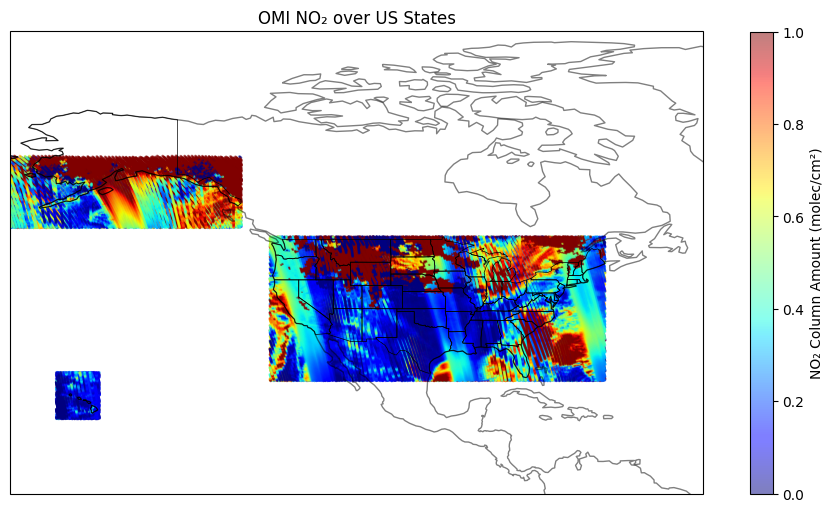

In [12]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 5, 85], crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
scatter = ax.scatter(global_longitude, global_latitude, c=global_cloudFraction, s=1, cmap='jet', transform=ccrs.PlateCarree(), alpha=0.5)
plt.colorbar(scatter, label='NO₂ Column Amount (molec/cm²)', orientation='vertical')
plt.title('OMI NO₂ over US States')
plt.show()

Perfect. Our bounding box and data filtration logic is valid. Lets process data files one month at a time and export them to not run out of memory.

In [8]:
import random

random.sample(omi_no2_links, 10)

['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/042/OMI-Aura_L2-OMI_MINDS_NO2_2020m0211t1604-o082852_v01-01-2022m0210t053236.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/038/OMI-Aura_L2-OMI_MINDS_NO2_2020m0207t1131-o082791_v01-01-2022m0210t052904.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/207/OMI-Aura_L2-OMI_MINDS_NO2_2021m0726t1505-o090584_v01-01-2022m0210t121032.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/306/OMI-Aura_L2-OMI_MINDS_NO2_2021m1102t2202-o092030_v01-01-2022m0210t134302.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2019/111/OMI-Aura_L2-OMI_MINDS_NO2_2019m0421t1205-o078539_v01-01-2022m0210t024711.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/132/OMI-Aura_L2-OMI_MINDS_NO2_2020m0511t1830-o084164_v01-01-2022m0210t062259.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/290/OMI-Aura_L2-OMI_MINDS_NO2_2018m1017

In [14]:

def get_s3links_for_selected_date(year: str, month:str) -> list[str]:
    """
    Get the S3 links for a specific year and month.
    """
    month_str = f"{int(month):02d}"
    pattern = re.compile(rf'.*OMI_MINDS_NO2_{year}m{month_str}\d{{2}}t\d{{4}}.*\.nc$')
    files = sorted([file for file in omi_no2_links if pattern.search(file)])
    return files

In [15]:
def process_data_monthly(year: str, month: str):
    '''
    Read the OMI NO2 data files for a specific month and year from S3 bucket and export it.
    '''
    try:
        omi_no2_links_for_selected_YYYYMM = get_s3links_for_selected_date(year, month)
        
        dfs = []

        for current_file in tqdm(omi_no2_links_for_selected_YYYYMM):
            try:
                with s3_fs.open(current_file, mode="rb") as f:
                    with nc.Dataset("in-memory.nc", memory=f.read()) as dataset:
                        filename = os.path.basename(current_file)
                        date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
                        
                        # Extract data
                        ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
                        cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
                        latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
                        longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
                        corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
                        corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
                        
                        # Create boolean mask
                        boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])
                        
                        # Filter data
                        filtered_data = {
                            "latitude": latitude[boolean_mask],
                            "longitude": longitude[boolean_mask],
                            "ColumnAmountNO2": ColumnAmountNO2[boolean_mask],
                            "cloudFraction": cloudFraction[boolean_mask],
                            "LAT1": corner_latitude[:, 0][boolean_mask],
                            "LAT2": corner_latitude[:, 1][boolean_mask],
                            "LAT3": corner_latitude[:, 2][boolean_mask],
                            "LAT4": corner_latitude[:, 3][boolean_mask],
                            "LON1": corner_longitude[:, 0][boolean_mask],
                            "LON2": corner_longitude[:, 1][boolean_mask],
                            "LON3": corner_longitude[:, 2][boolean_mask],
                            "LON4": corner_longitude[:, 3][boolean_mask],
                            "date": np.repeat(date, np.sum(boolean_mask))
                        }
                        
                        dfs.append(pd.DataFrame(filtered_data))
            
            except Exception as e:
                print(f"Error processing file {current_file}: {str(e)}")
                continue

        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            output_path = f"omi_no2_data_{year}_{month}.parquet"
            final_df.dropna(inplace=True)
            final_df.reset_index(drop=True, inplace=True)
            final_df.to_parquet(output_path)
        else:
            print("No valid data processed for the given month.")

        return True 
    except Exception as e:
        print(f"Error processing data for {year}-{month}: {str(e)}")
        return False

In [16]:
from joblib import Parallel, delayed

It is taking roughly 3 minutes to process one month of data. Therefore, I will utilize joblib to parallize this process. This way, I can process data for multiple months simultaneously to reduce the total processing time. Each daily file is ~10 MB and reading though them, filtering exporting month file takes some time. Each exported monthly file is ~30MB.

In [17]:
def proces_data_in_parallel(year_selected: str, num_cores= 6):
    """
    This function will process multiple months in parallel for a given year
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    Parallel(n_jobs=num_cores)(delayed(process_data_monthly)(year, month) for year in [year_selected] for month in months)

In [ ]:
proces_data_in_parallel("2018")
proces_data_in_parallel("2019")
proces_data_in_parallel("2020")

In [13]:
proces_data_in_parallel("2020")

100%|██████████| 414/414 [04:32<00:00,  1.52it/s]


In [14]:
proces_data_in_parallel("2021")

100%|██████████| 432/432 [04:38<00:00,  1.55it/s]


In [15]:
proces_data_in_parallel("2022")

100%|██████████| 409/409 [03:55<00:00,  1.73it/s]


In [18]:
proces_data_in_parallel("2023")

100%|██████████| 428/428 [04:22<00:00,  1.63it/s]


In [19]:
proces_data_in_parallel("2024")

100%|██████████| 416/416 [04:50<00:00,  1.43it/s]


# 3. NO2 Pollution Analysis

In [13]:
files_path = "Data/NO2/Single_Files"
files = os.listdir(files_path)
files = [os.path.join(files_path, file) for file in files if file.endswith(".parquet")]
files = sorted(files)

In [14]:
len(files), files[0], files[-1]

(84,
 'Data/NO2/Single_Files\\omi_no2_data_2018_01.parquet',
 'Data/NO2/Single_Files\\omi_no2_data_2024_12.parquet')

If we look here, each parquet file is the NO2 data for US for each month (daily of course). We will read each parquet file into spark data frame and concat them.

In [18]:
no2_df = spark.read.parquet(files[0])

In [19]:
no2_df.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018m0101|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018m0101|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018m0101|
|40.591774| -67.17118|  1.86005531E15|             0.717|40.1422|40.7938|41.0213| 40.398|-67.9063|-66.2838|-66.4199|-68.0655|2018m0101|
|  40.7019|-67.238594|  2.01618274E15|0.69600000

Here, latitude, longitude and their corner cordinates are geographical information that can be used to perform spatial analysis. ColumnAmountNO2 is the OMI NO2 vertical column density whereas cloudFraction refers to the percentage/fraction of sky covered with clouds at the specific cordinates. If the value of cloud fraction is large, the OMI instrument's NO2 column values will not be accurate as cloud reflects sunlight and the measurement become inaacurate. Therefore, we will later only use data where cloud fraction is less than 0.5. The higher the threshold we set, the more data we loose. 

In [22]:
no2_df

DataFrame[latitude: float, longitude: float, ColumnAmountNO2: float, cloudFraction: double, LAT1: float, LAT2: float, LAT3: float, LAT4: float, LON1: float, LON2: float, LON3: float, LON4: float, date: string]

In [45]:
min_lat = 37
max_lat = 40.25
min_lon = -80
max_lon = 73.5

import geopandas as gpd
from shapely.geometry import Polygon

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
bounding_box = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bounding_box])

In [50]:
from pyspark.sql.functions import col

In [55]:
no2_df = no2_df.filter((col("latitude") >= min_lat) & (col("latitude") <= max_lat) & (col("longitude") >= min_lon) & (col("longitude") <= max_lon))
no2_df = no2_df.filter(
    (col("longitude") >= min_lon) & 
    (col("longitude") <= max_lon) & 
    (col("latitude") >= min_lat) & 
    (col("latitude") <= max_lat)
)

In [58]:
no2_df = no2_df.toPandas()

In [59]:
no2_df["geometry"] = gpd.points_from_xy(no2_df["longitude"], no2_df["latitude"])
no2_df = gpd.GeoDataFrame(no2_df, geometry="geometry", crs="EPSG:4326")

In [60]:
maryland = gpd.read_file(r'Data\US_SHAPEFILES\State_Boundary\us-state-boundaries.shp')
maryland = maryland[maryland.name == 'Maryland'][["geometry"]].reset_index(drop=True)

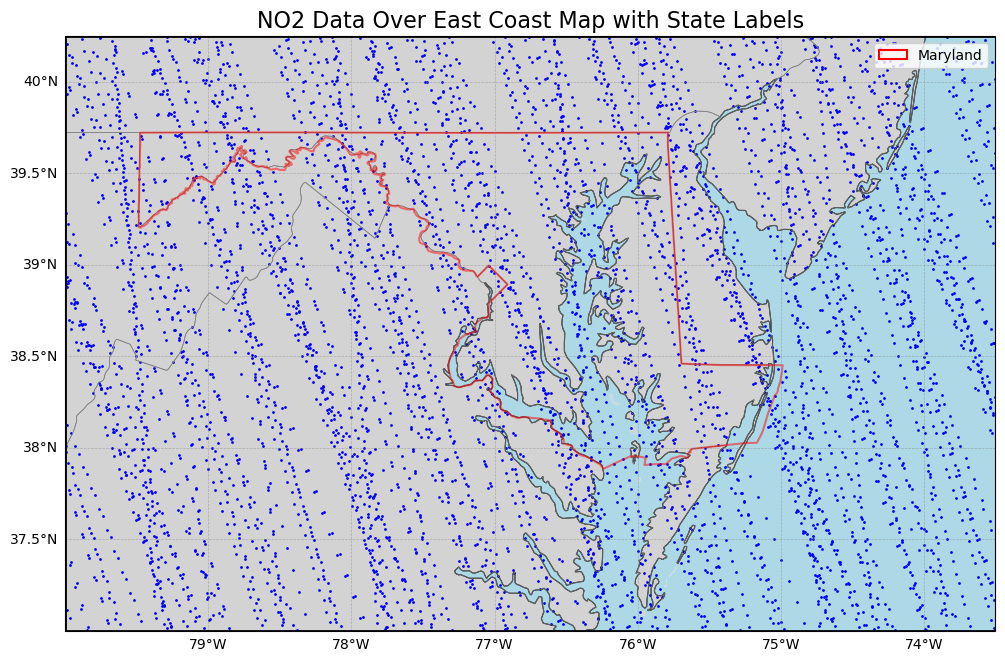

In [64]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-80, -73.5, 37, 40.25], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot Maryland boundary
maryland.geometry.boundary.plot(ax=ax, color='red', linewidth=1.5, alpha=0.5, transform=ccrs.PlateCarree())
bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
red_patch = mpatches.Patch(color='red', label='Maryland', fill=False, linewidth=1.5)
ax.legend(handles=[red_patch], loc='upper right', fontsize=10)
no2_df.plot(ax=ax, color="blue", markersize=1, alpha=1, legend=False, transform=ccrs.PlateCarree())
plt.title("NO2 Data Over East Coast Map with State Labels", fontsize=16)
plt.show()

In [76]:
df = spark.read.parquet(files[0])

In [77]:
for file in tqdm(files[1:]):
    try:
        no2_df = spark.read.parquet(file)
        no2_df = no2_df.filter((col("latitude") >= min_lat) & (col("latitude") <= max_lat) & (col("longitude") >= min_lon) & (col("longitude") <= max_lon))
        no2_df = no2_df.filter(
            (col("longitude") >= min_lon) & 
            (col("longitude") <= max_lon) & 
            (col("latitude") >= min_lat) & 
            (col("latitude") <= max_lat) &
            (col("ColumnAmountNO2") > 0) &
            (col("cloudFraction") < 0.5) 
        )
        
        df = df.union(no2_df)
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

100%|██████████| 83/83 [00:06<00:00, 12.81it/s]


In [78]:
df.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018m0101|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018m0101|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018m0101|
|40.591774| -67.17118|  1.86005531E15|             0.717|40.1422|40.7938|41.0213| 40.398|-67.9063|-66.2838|-66.4199|-68.0655|2018m0101|
|  40.7019|-67.238594|  2.01618274E15|0.69600000

In [79]:
df.count()

1259870

In [80]:
from pyspark.sql.functions import to_date, regexp_replace

# Fix date format from "2018m0101" to "20180101" then to date
df = df.withColumn("date", to_date(regexp_replace("date", "m", ""), "yyyyMMdd"))

In [81]:
from pyspark.sql.functions import year, month, dayofmonth, date_format

df = df.withColumn("year", year("date")) \
       .withColumn("month", month("date")) \
       .withColumn("day", dayofmonth("date")) \
       .withColumn("dayname", date_format("date", "EEEE"))


In [82]:
df.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|      date|year|month|day|dayname|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018-01-01|2018|    1|  1| Monday|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018-01-01|2018|    1|  1| Monday|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018-01-01|2018|    1|  1| Monday|
|40.591774| -67.17118|  1.86005531E15|  

In [84]:
df = df.withColumn("year_month", date_format("date", "yyyy-MM"))
df.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+----------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|      date|year|month|day|dayname|year_month|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+----------+----+-----+---+-------+----------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018-01-01|2018|    1|  1| Monday|   2018-01|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018-01-01|2018|    1|  1| Monday|   2018-01|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018-01-01|2018|    

In [87]:
from pyspark.sql.functions import avg

monthly_avg_df = df.groupBy("year_month").agg(avg("ColumnAmountNO2").alias("avg_NO2"))

In [88]:
monthly_avg_df = monthly_avg_df.toPandas()
monthly_avg_df

,year_month,avg_NO2
0,2018-01,3.351680e+15
1,2018-02,4.567711e+15
2,2018-03,6.121473e+15
3,2018-04,4.568938e+15
4,2018-05,4.482139e+15
...,...,...
79,2024-08,4.309930e+15
80,2024-09,3.561972e+15
81,2024-10,3.985977e+15
82,2024-11,4.352548e+15


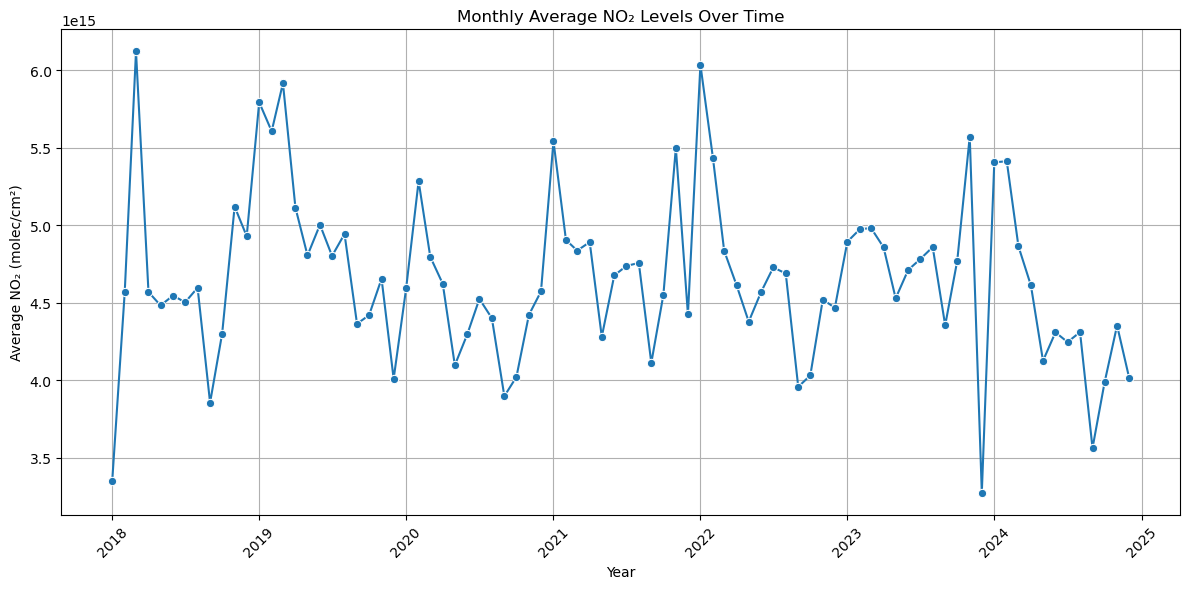

In [91]:
import seaborn as sns
import matplotlib.dates as mdates

# Convert year_month to datetime for better handling
monthly_avg_df["year_month"] = pd.to_datetime(monthly_avg_df["year_month"])

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_df, x="year_month", y="avg_NO2", marker="o")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show ticks for each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.title("Monthly Average NO₂ Levels Over Time")
plt.xlabel("Year")
plt.ylabel("Average NO₂ (molec/cm²)")
plt.grid(True)
plt.tight_layout()
plt.show()